In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

In [2]:
img_size=256
Batch_size=32

# Data Collection

In [4]:
#loading dataset using tf dataset rather than standart read_csv as it will load our images directly

dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size=(img_size,img_size),
    batch_size=Batch_size
    
    
)

Found 2147 files belonging to 3 classes.


In [6]:
#Getting subdirectories names
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
#the result is 68 as images are bundled in a batch of 32 so 32*68 is total number of images
len(dataset)

68

# Exploring Data

In [9]:
#This implies we have a batch of 32 images and every element is a tensor so we need to convert to numpy
#label_batch is which class does the image belongs to 0-early_blight 1-late_blight
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 0 0 0 0 1 0 0 0 1 2 1 0 0 0 1 0 1 2 1 1 1 0 0 1 1 0 1 2 1 0]


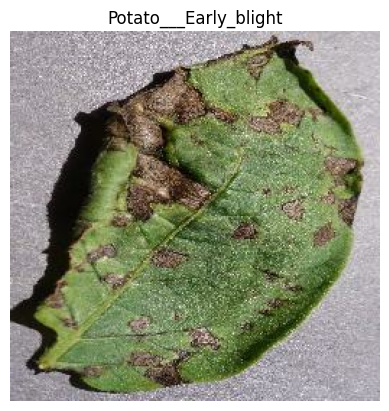

In [13]:
#Visualizing the images/tensor
for image_batch,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[0]])

# Splitting dataset

In [16]:
#Figuring out how many samples we need for training
train_size=0.8
train_num=len(dataset)*train_size
train_num

54.400000000000006

In [19]:
#Figuring out how many samples we need for validation
val_size=0.1
val_num=len(dataset)*val_size
val_num

6.800000000000001

# Function for splitting dataset rather than conventional train_test_split

In [26]:

def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if(shuffle):
        ds=ds.shuffle(shuffle_size,seed=12)
    
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [27]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)
len(train_ds)

54

In [28]:
len(test_ds)

8

In [30]:
#using cache so that whenever same image is requested again it will be there in memory
#prefetch will make use of both cpu and gpu eg-gpu is processing cpu is loading
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Scaling image b/w 0-1 as its rgb so its b/w 0-255 as of now

In [36]:
#scaling using tensorflow layer
#we will supply this layer once we build our model
resize_and_scale=tf.keras.Sequential(
    [
         layers.experimental.preprocessing.Resizing(img_size,img_size),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ]
)

# Data augmentaion
we are also supllying augmention layer so that if we need to analyse a rotated image we can do that

In [37]:
data_augmentation=tf.keras.Sequential(
    [
         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2)
    ]
)

data_augmentation_imagedatagenerator=tf.keras.Sequential(
    [
         layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2)
    ]
)

# Building an cnn

In [44]:
input_shape=(Batch_size,img_size,img_size,3)
n_classes=3
model=models.Sequential(
    [
        resize_and_scale,
        data_augmentation,
        layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),

        layers.Dense(64,activation='relu'),
        layers.Dense(n_classes,activation='softmax')
        
        
    ]
)
model.build(input_shape=input_shape)

In [45]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   multiple                  0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                 

In [46]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [47]:
EPOCHS=50
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 24s 238ms/step - loss: 0.9269 - accuracy: 0.4942 - val_loss: 0.8140 - val_accuracy: 0.6719
Epoch 2/50
54/54 [==============================] - 12s 218ms/step - loss: 0.6196 - accuracy: 0.7685 - val_loss: 0.4409 - val_accuracy: 0.8438
Epoch 3/50
54/54 [==============================] - 12s 220ms/step - loss: 0.3852 - accuracy: 0.8432 - val_loss: 0.3828 - val_accuracy: 0.8490
Epoch 4/50
54/54 [==============================] - 12s 218ms/step - loss: 0.3392 - accuracy: 0.8594 - val_loss: 0.2685 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 12s 219ms/step - loss: 0.2189 - accuracy: 0.9155 - val_loss: 0.2994 - val_accuracy: 0.8958
Epoch 6/50
54/54 [==============================] - 12s 219ms/step - loss: 0.2006 - accuracy: 0.9317 - val_loss: 0.1746 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 12s 219ms/step - loss: 0.2154 - accuracy: 0.9126 - val_loss: 0.2290 - val_accuracy: 0.9375

In [61]:
#Evaluating model
scores=model.evaluate(test_ds)

8/8 [==============================] - 0s 35ms/step - loss: 0.0586 - accuracy: 0.9766


In [63]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [64]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and validation Accuracy')

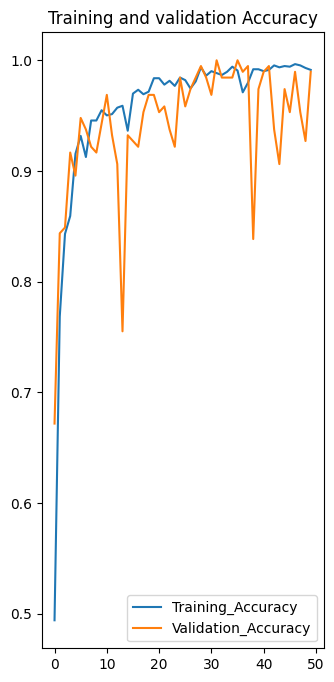

In [65]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training_Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation_Accuracy')
plt.legend(loc='lower right')
plt.title("Training and validation Accuracy")

# Making predictions

first image to be predicted
Its label is:  Potato___Late_blight
1/1 [==============================] - 0s 131ms/step
first image predicted is:  Potato___Late_blight


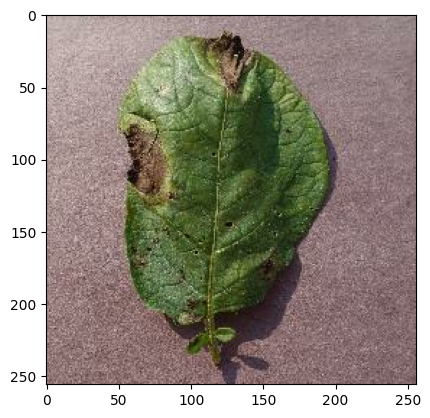

In [68]:
for image_batch,labels_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0]
    print("first image to be predicted")
    plt.imshow(first_image)
    print("Its label is: ",class_names[first_label])

    batch_prediction=model.predict(image_batch)
    print("first image predicted is: ",class_names[np.argmax(batch_prediction[0])])
    
    

In [69]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 19ms/step


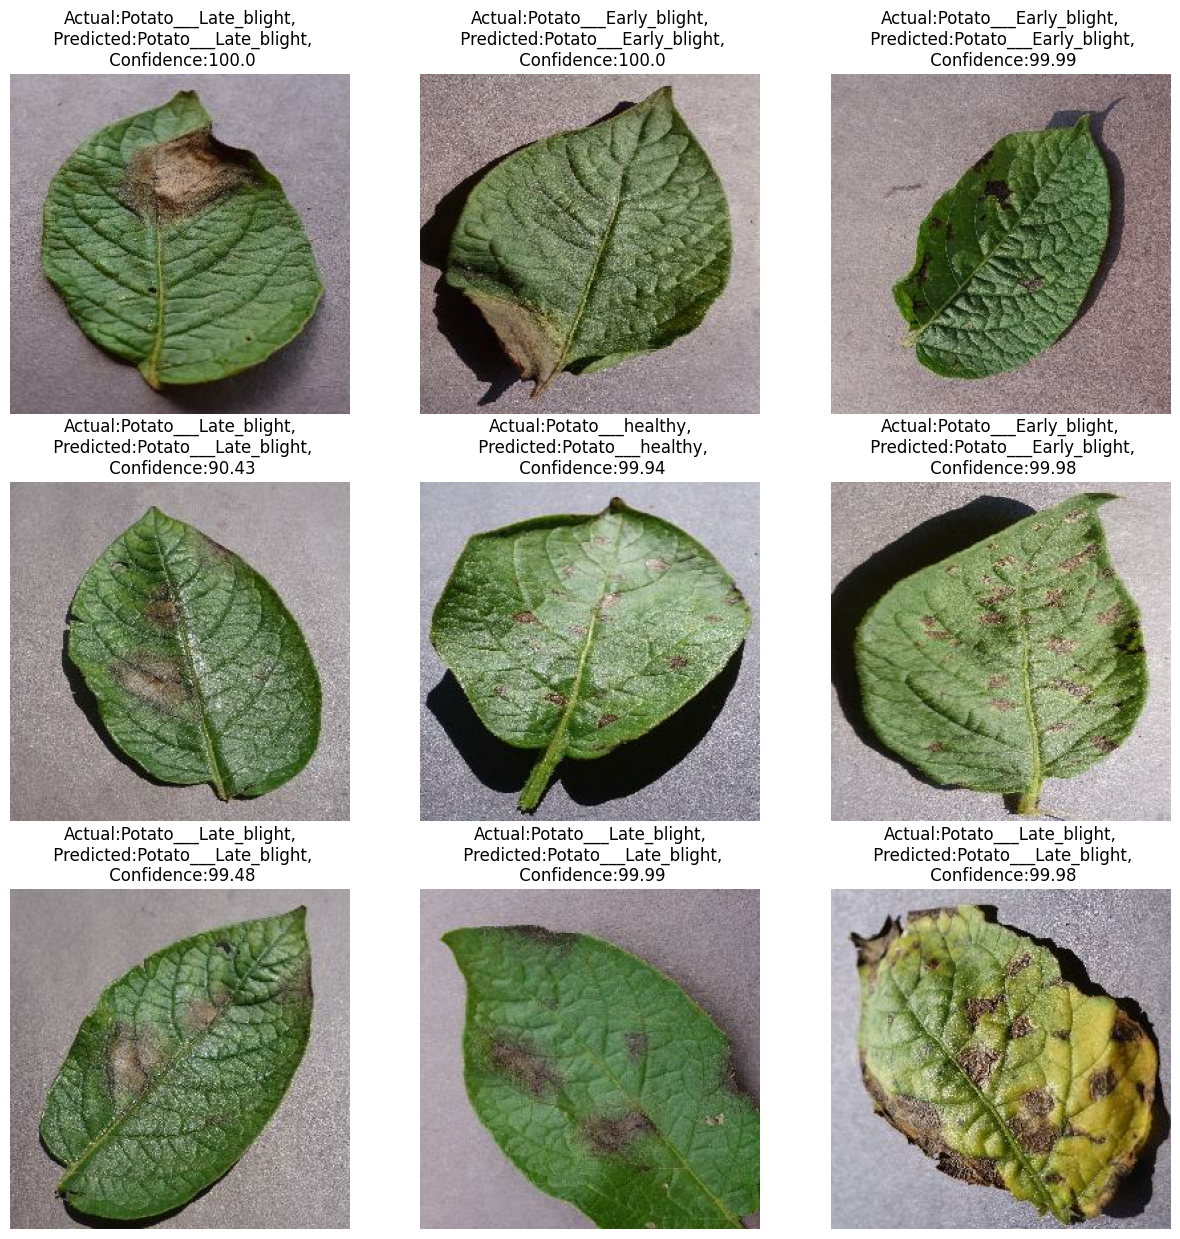

In [77]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[label[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class},\n Confidence:{confidence}")
        plt.axis("off")
    

In [78]:
model_version=1;
model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/1\assets


INFO:tensorflow:Assets written to: ../model/1\assets


In [4]:
import sys

loaded_model = tf.keras.models.load_model(f"../model/1")
model_size = sys.getsizeof(loaded_model)

print(f"Model size: {model_size} bytes")

Model size: 48 bytes


In [11]:
img_path = "PlantVillage/Potato___healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG"  # Replace this with the path to your image
img_size = 256  # Assuming the image size used during training is 224x224
img = image.load_img(img_path, target_size=(img_size, img_size))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

In [8]:
predictions = loaded_model.predict(img_array)

# The predictions will be probabilities for each class
# If you want to get the predicted class, you can use argmax
predicted_class = np.argmax(predictions)


1/1 [==============================] - 5s 5s/step


2